# Sentiment Analysis

We've already demonstrated how to train a character-level RNN to create original text. In this chapter, we create a **word-level** to analyze sentiment.

Sentiment analysis is a common NLP task. **Sentiment analysis** computationally identifies and categorizes opinions expressed in a text corpus to determine attitude or sentiment. Typically, sentiment analysis is used to determine a positive, negative or neutral opinion towards a particular topic or product. This technique is widely applied to reviews, surveys, and documents.

# IMDb Dataset

A popular dataset used to practice NLP is the IMDb reviews dataset. **IMDb** is a benchmark dataset for binary sentiment classification. The dataset contains 50,000 movie reviews labeled as either positive (1) or negative (0). Reviews are preprocessed with each encoded as a sequence of word indexes in the form of integers. Words within the reviews are indexed by their overall frequency within the dataset. The 50,000 reviews are split into 25,000 for training and 25,000 for testing. So, we can predict the number of positive and negative reviews using either classification or other deep learning algorithms.

IMDb is popular because it is simple to use, relative easy to process, and challenging enough for machine learning aficionados. We enjoy working with IMDb because it's just fun to work with movie data.

As usual, we need to set up the GPU for each notebook. So, click the **Runtime** tab, click **Change runtime type** from the drop-down menu, choose **GPU** from the Hardware Accelerator drop-down menu, and click **Save**.

In [1]:
import tensorflow as tf

# display tf version and test if GPU is active

tf.__version__, tf.test.gpu_device_name()

('2.3.0', '/device:GPU:0')

Import the tensorflow library. If '/device:GPU:0' is displayed, the GPU is active. If '..' is displayed, the regular CPU is active.

# Load IMDb as a TFDS

The recommended way to load IMDb is as a TFDS:

In [2]:
import tensorflow_datasets as tfds

imdb, info = tfds.load(
    'imdb_reviews/subwords8k', with_info=True,
    as_supervised=True, shuffle_files=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteUCZLGB/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteUCZLGB/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteUCZLGB/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


We use the **imdb_reviews/subwords8k** TFDS so we train the model on a smaller vocabulary. The *subwords8k* subset has a vocabulary size of 8,000, which means that we are training the model on the 8,000 most commonly used words in the reviews. It also means that we don't have to build our own vocabulary dictionary. We can get good performance with this subset and substantially reduce training time. Loading the TFDS also gives us access to the **tfds.features.text.SubwordTextEncoder**, which is the TFDS text encoder.

We set **with_info=True** to enable access to information about the dataset and the encoder. We set **as_supervised=True** so the returned TFDS has a 2-tuple structure (input, label) in accordance to builder.info.supervised_keys. If set to *False* (the default), the returned TFDS will have a dictionary with all features included. We set **shuffle_files=True** because shuffling typically improves performance.

For more information about all features of a TFDS, peruse the following URL:

https://www.tensorflow.org/datasets/api_docs/python/tfds/load

For more infor about 'imdb_reviews', peruse the following URL:

https://www.tensorflow.org/datasets/catalog/imdb_reviews

## Display the Keys

In [3]:
imdb.keys()

dict_keys(['test', 'train', 'unsupervised'])

By displaying the keys, we know that the dataset is split into test, train, and unsupervised samples.

## Split into Train and Test Sets

Since we are building a supervised model, we are only interested in the train and test samples.

In [4]:
train, test = imdb['train'], imdb['test']

## Display the First Sample

Display the first review and its label from the training sample.

In [5]:
br ='\n'

for sample, target in train.take(1):
  print ('encoded review:')
  print (sample, br)
  print ('target:', target.numpy())

encoded review:
tf.Tensor(
[  12   31   93  867    7 1256 6585 7961  421  365    2   26   14    9
  988 1089    7    4 6728    6  276 5760 2587    2   81 6118 8029    2
  139 1892 7961    5 5402  246   25    1 1771  350    5  369   56 5397
  102    4 2547    3 4001   25   14 7822  209   12 3531 6585 7961   99
    1   32   18 4762    3   19  184 3223   18 5855 1045    3 4232 3337
   64 1347    5 1190    3 4459    8  614    7 3129    2   26   22   84
 7020    6   71   18 4924 1160  161   50 2265    3   12 3983    2   12
  264   31 2545  261    6    1   66    2   26  131  393    1 5846    6
   15    5  473   56  614    7 1470    6  116  285 4755 2088 7961  273
  119  213 3414 7961   23  332 1019    3   12 7667  505   14   32   44
  208 7975], shape=(142,), dtype=int64) 

target: 0


Each example in both train and test sets contain contain a review tensor and a label tensor. Reviews are already encoded as integers with datatype 'int64'. Labels are either 0 (negative) or 1 (positive) with datatype 'int64'.

We know the number of words in the sample review by looking at its shape. We also display the target. Notice, that we convert the target tensor to values with the **numpy()** method.

## Display Information about the TFDS

In [6]:
# see all of the information!

info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

## Peruse Metadata

See train and test sample splits:

In [7]:
# see the train and test sample splits

train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples

train_size, test_size

(25000, 25000)

See supervised keys:

In [8]:
info.supervised_keys

('text', 'label')

See feature information:

In [9]:
info.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

See TFDS name and a slice of its description:

In [10]:
info.name, info.description[0:25]

('imdb_reviews', 'Large Movie Review Datase')

We can even slice the citation string to get the title:

In [11]:
info.citation[184:242]

'title     = {Learning Word Vectors for Sentiment Analysis}'

## Create the Encoder

An encoder is built-into the TFDS *SubwordTextEncoder*. With the encoder, we can easily decode (integer to text) and encode (text to integer). We access the encoder from dataset **info**.

 Create an encoder based on the IMDb dataset we loaded into memory.

In [12]:
encoder = info.features['text'].encoder

## Test the Encoder

In [13]:
sample_string = 'What a Beautiful Day!'

encoded_string = encoder.encode(sample_string)
print ('Encoded string:', encoded_string)

original_string = encoder.decode(encoded_string)
print ('Original string:', original_string)

Encoded string: [274, 4, 6555, 5392, 7961, 2431, 7962]
Original string: What a Beautiful Day!


## Use the Encoder

Create a function that returns the label rating:

In [14]:
def rev(d):
  if tf.math.equal(d, 0): return 'negative review'
  elif tf.math.equal(d, 1): return 'positive review'

Display the first review:

In [16]:
for sample, target in train.take(1):
  print ('review:', end=' ')
  text = encoder.decode(sample)
  print (text[0:100])
  print ('opinion:', end=' ')
  print ('\'' + rev(target) + '\'')

review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. 
opinion: 'negative review'


Display multiple reviews:

In [17]:
n = 6

for i, sample in enumerate(train.take(n)):
  if i > 0:
    print ('review', str(i+1) +':', end=' ')
    text = encoder.decode(sample[0])
    print (text[0:100])
    print ('opinion:', end=' ')
    print ('\'' + rev(sample[1]) + '\'')
    if i < n-1:
      print ()

review 2: I have been known to fall asleep during films, but this is usually due to a combination of things in
opinion: 'negative review'

review 3: Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brenn
opinion: 'negative review'

review 4: This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with i
opinion: 'positive review'

review 5: As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. Th
opinion: 'positive review'

review 6: This is a film which should be seen by anybody interested in, effected by, or suffering from an eati
opinion: 'positive review'


We skip the first review because we've already seen it.

Display vocabulary size:

In [18]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


## Finish the Input Pipeline

Create batches of the encoded strings (or reviews) to greatly enhance performance. Since machine learning algorithms expect batches of the same size, use the **padded_batch** method to zero-pad the sequences so that each review is the same length as the longest string in the batch.

Initialize variables:

In [19]:
# initialize variables

BUFFER_SIZE = 10000
BATCH_SIZE = 64

Shuffle (where appropriate) and batch train and test sets:

In [22]:
train_ds = (train
            .shuffle(BUFFER_SIZE)
            .padded_batch(BATCH_SIZE)
            .cache().prefetch(1))

test_ds = (test
           .padded_batch(BATCH_SIZE)
           .cache().prefetch(1))

Consult the following URL for updates on padding character tensors:

https://www.tensorflow.org/tutorials/text/text_classification_rnn

## Create the Model

In [24]:
import numpy as np

# generate seed for reproducibility
tf.random.set_seed(0)
np.random.seed(0)

# import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense,\
Embedding

# clear any previous models
tf.keras.backend.clear_session()

# build the model
embed_size = 128
model = Sequential([
  Embedding(encoder.vocab_size, embed_size, mask_zero=True,
            input_shape=[None]),
  GRU(128, return_sequences=True),
  GRU(128),
  Dense(1, activation="sigmoid")
])

The first layer is an *Embedding* layer. The **Embedding** layer is used to create word vectors for incoming words. During training, representations of word categories (or word vectors) are learned in a way where similar categories are closer to one another. So, word vectors can store relationships between words like *good* and *great*. Word vectors are dense because our model learns word relationships. As a result, word vectors aren't padded with a huge number of zeros like what we do with one-hot encodings.

The Embedding layer accepts the vocabulary size, embedding size, and input shape. We set **mask_zero=True** to inform the model to ignore padding tokens by all downstream layers. Ignoring padding tokens improves performance.

The next two layers are GRU layers and the final layer is a single neuron output layer. The output layer uses sigmoid activation to output the estimated probability that the review expresses a positive or negative sentiment regarding the movie.

## Model Summary

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1047680   
_________________________________________________________________
gru (GRU)                    (None, None, 128)         99072     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,245,953
Trainable params: 1,245,953
Non-trainable params: 0
_________________________________________________________________


## Compile the Model

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

## Train the Model

From multiple experiments, we found that 2 epochs provide good accuracy without tuning. As we increased the number of epochs, we noticed overfitting. Of course, you can experiment to your heart's content. As a caveat, training text models requires a lot of training time!

In [27]:
# to suppress unuseful error messages

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

history = model.fit(train_ds, epochs=2,
                    validation_data=test_ds)

Epoch 1/2
391/391 [==============================] - 73s 187ms/step - loss: 0.5761 - accuracy: 0.6844 - val_loss: 0.3743 - val_accuracy: 0.8342
Epoch 2/2
391/391 [==============================] - 68s 175ms/step - loss: 0.2679 - accuracy: 0.8882 - val_loss: 0.3146 - val_accuracy: 0.8755


## Generalize on Test Data

Although model fit information provides validation loss and accuracy values during training, it is always a good idea to explictly evaluate the model on test data because accuracy and loss values can differ.

In [28]:
test_loss, test_acc = model.evaluate(test_ds)

391/391 [==============================] - 21s 55ms/step - loss: 0.3146 - accuracy: 0.8755


## Visualize

Visualize training performance:

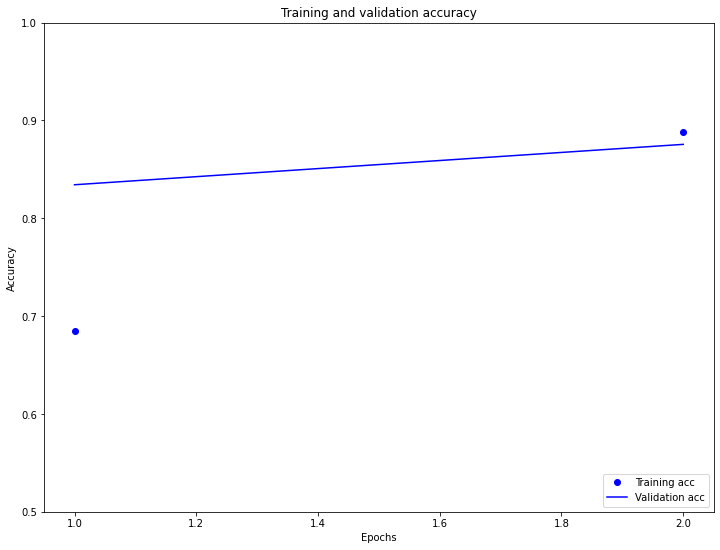

<Figure size 432x288 with 0 Axes>

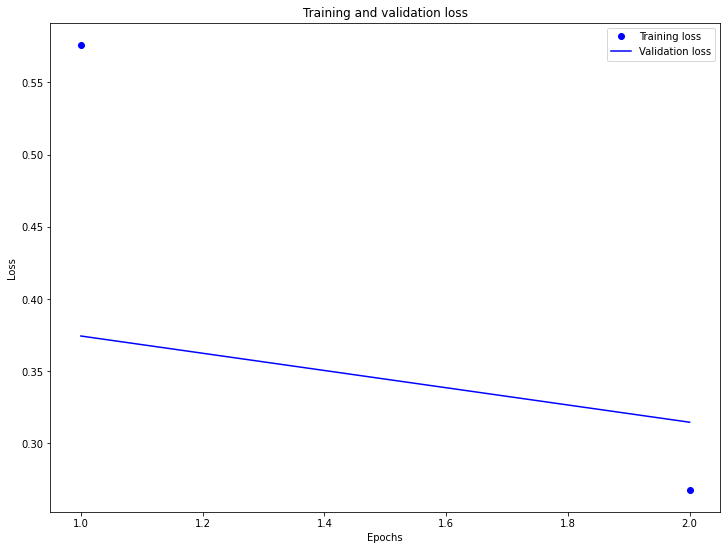

In [30]:
import matplotlib.pyplot as plt

# history.history contains the training record

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

# clear previous figure

plt.clf()

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Make Predictions from Fabricated Reviews

Let's make predictions from reviews that we fabricate. Begin by creating a function that returns the predictions. Since we create our own reviews, the function must convert the text review for TensorFlow consumption.

In [31]:
def predict_review(text):
  encoded_text = encoder.encode(text)
  encoded_text = tf.cast(encoded_text, tf.float32)
  prediction = model.predict(tf.expand_dims(encoded_text, 0))
  return prediction

The function accepts a text review. It begins by encoding the review. Next, it converts the encoded review to float32. The function then makes the prediction. We add the '1' dimension to the encoded text so it can be consumed by the model.

Test the function with a fabricated review:

In [32]:
review = ('Just loved it. My kids thought the movie was cool. '
         'Even my wife liked it.')

pred = predict_review(review)
pred, pred.shape

(array([[0.9924075]], dtype=float32), (1, 1))

We have a prediction. Predictions greater than 0.5 mean that the review is positive. Otherwise, the review is negative.

 Make the prediction more palatable by creating another function:

In [33]:
def palatable(pred):
  score = tf.squeeze(pred, 0).numpy()
  return score[0]

Invoke the function:

In [34]:
score = palatable(pred)
score, score.shape

(0.9924075, ())

The function removes the *1* dimension from the prediction. Notice that the new shape is a scalar.

Let's go function crazy by creating one that returns whether the review is positive or negative.

In [35]:
def impression(score):
  if score >= 0.5:
    return 'positive impression'
  else:
    return 'negative impression'

Invoke the function:

In [36]:
impression(score)

'positive impression'

As expected, the review is positive.

Let's try another one:

In [37]:
review = ('The movie absolutely sucked. '
          'No character development. '
          'Dialogue just blows.')

pred = predict_review(review)
score = palatable(pred)
print (impression(score))

negative impression


As expected, the review is negative.

## Make Predictions on a Test Data Batch

We can also predict from the test set. Let's make predictions on the first test batch with the *predict* method. Since test data is already in tensor form, we don't need to encode.

In [38]:
# get predictions from 1st test batch
for sample, target in test_ds.take(1):
  y_pred_64 = model.predict(sample)

# display first review from this batch
print ('review:', end=' ')
print (encoder.decode(sample[0])[177:307])

# display first label from this batch
print ('label:', end=' ')
print (target[0].numpy(), br)

# display number of examples in the batch
print ('samples and target in first batch:', end=' ')
len(sample), len(target)

review: absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies.
label: 1 

samples and target in first batch: 

(64, 64)

Variable **y_pred_64** holds 64 predictions because we take the first batch of 64 from the TensorFlow consumable **test_ds**. We then display the first review and its associated label from this batch. Remember that label *1* means the review was positive and label *0* means it was negative. We end by displaying the size of the sample and target to verify that we have 64 examples in our first batch.

Get the first prediction:

In [43]:
print (y_pred_64[0])

[0.20822671]


Make it palatable:

In [44]:
impression(y_pred_64[0])

'negative impression'

Compare prediction to actual label:

In [46]:
impression(y_pred_64[0]), impression(target[0].numpy())

('negative impression', 'positive impression')

If the prediction matches the actual label, it was correct. Remember that an actual label of *1* is positive and an actual label of *0* is negative.

Display prediction efficacy for the first five predictions:

In [47]:
for i in range(5):
  p = impression(y_pred_64[i])
  t = impression(target[i].numpy())
  print (i, end=': ')
  if p == t: print ('correct')
  else: print ('incorrect')

0: incorrect
1: correct
2: correct
3: correct
4: correct


## Prediction Accuracy for the First Batch

Create a function to convert an impression back to a label of either 1 or 0:

In [48]:
def convert_label(feeling):
  if feeling == 'positive impression':
    return 1
  else: return 0

Return prediction accuracy for the entire first batch:

In [49]:
ls = []
n = len(target)
for i, _ in enumerate(range(n)):
  t = target[i].numpy() # labels
  p = convert_label(impression(y_pred_64[i])) # predictions
  if t == p: ls.append(True)
correct = ls.count(True)
acc = correct / n
batch_accuracy = str(int(np.round(acc, 2) * 100)) + '%'
print ('accuracy for the first batch:', batch_accuracy)

accuracy for the first batch: 77%


We begin by traversing the first batch and comparing labels to predictions. If a prediction is correct, we add this information to a list. We continue by counting the number of correct predictions. We end by dividing correct predictions by the batch size to get overall prediction accuracy.

# Leverage Pretrained Embeddings

Amazingly, we can reuse modules from pretrained models on the IMDb dataset. The TensorFlow Hub project is a library with hundreds of reusable machine learning modules. A **module** is a self-contained piece of a TensorFlow graph, along with its weights and assets, that can be reused across different tasks in a process known as transfer learning. **Transfer learning** is a machine learning method where a model developed for a task is reused as the starting point for a model on a different task.

You can browse the library by perusing the following URL:

http://tfhub.dev

Once you locate a module, copy the URL into your model. The module is automatically dowloaded along with its pretrained weights. A huge advantage of using pretrained models is that we don't have to create and train our own models from scratch!

## Load IMDb Data

Since we are using a pretrained model, we can load the *entire* IMDb data:

In [50]:
data, info = tfds.load('imdb_reviews', as_supervised=True,
                       with_info=True, shuffle_files=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteU0ODOE/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteU0ODOE/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteU0ODOE/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


We use the full vocabulary because we don't have to worry about training with it!

## Build the Input Pipeline

Create train and test sets:

In [51]:
train, test = data['train'], data['test']

Batch and prefetch:

In [54]:
# finalize the input pipeline

batch_size = 32
train_set = train.repeat().batch(batch_size).prefetch(1)
test_set = test.batch(batch_size).prefetch(1)

## Create the Pretrained Model

Import the TF Hub library and create a skeleton model to house the pretrained module.

In [59]:
import tensorflow_hub as hub

# clear any previous models
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
  hub.KerasLayer(
      'https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1',
      dtype=tf.string, input_shape=[], output_shape=[50]),
  Dense(128, activation='relu'),
  Dense(1, activation='sigmoid')
])

The **hub.KerasLayer** downloads the sentence encoder module. Each string input into this layer is automatically encoded as a 50D vector. So, each vector represents 50 words. Each word is embedded based on an embedding matrix pretrained on the 7 billion word Google News corpus. The next two dense layers are added to provide a basic model for sentiment analysis. Using TF Hub is convenient and efficient because we can use what was already learned from the pretrained model.

## Compile

In [60]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Train

In [61]:
# to suppress unimportant error messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

history = model.fit(train_set,
                    steps_per_epoch=train_size // batch_size,
                    epochs=5, validation_data=test_set)

Epoch 1/5
781/781 [==============================] - 9s 12ms/step - loss: 0.5473 - accuracy: 0.7254 - val_loss: 0.5270 - val_accuracy: 0.7370
Epoch 2/5
781/781 [==============================] - 9s 11ms/step - loss: 0.5150 - accuracy: 0.7470 - val_loss: 0.5190 - val_accuracy: 0.7434
Epoch 3/5
781/781 [==============================] - 9s 12ms/step - loss: 0.5099 - accuracy: 0.7513 - val_loss: 0.5156 - val_accuracy: 0.7450
Epoch 4/5
781/781 [==============================] - 9s 11ms/step - loss: 0.5061 - accuracy: 0.7540 - val_loss: 0.5133 - val_accuracy: 0.7471
Epoch 5/5
781/781 [==============================] - 9s 11ms/step - loss: 0.5030 - accuracy: 0.7567 - val_loss: 0.5112 - val_accuracy: 0.7479


As expected, training time is much reduced!

## Predict

Let's make predictions on the first batch. Since our batch size is 32, we have 32 predictions in each batch.

In [62]:
for sample, target in test_set.take(1):
  y_pred_32 = model.predict(sample)

Display misclassifications:

In [63]:
for i in range(batch_size):
  p = convert_label(impression(y_pred_32[i]))
  l = target[i].numpy()
  if p != l:
    print ('pred:', p, 'actual:', l, 'indx:', i)

pred: 0 actual: 1 indx: 9
pred: 1 actual: 0 indx: 13
pred: 1 actual: 0 indx: 14
pred: 1 actual: 0 indx: 17
pred: 0 actual: 1 indx: 21
pred: 1 actual: 0 indx: 23
pred: 0 actual: 1 indx: 25


## Prediction Accuracy for First Batch

In [64]:
ls = []
n = len(target)
for i, _ in enumerate(range(n)):
  t = target[i].numpy() # labels
  p = convert_label(impression(y_pred_32[i])) # predictions
  if t == p: ls.append(True)
correct = ls.count(True)
acc = correct / n
batch_accuracy = str(int(np.round(acc, 2) * 100)) + '%'
print ('accuracy for the first batch:', batch_accuracy)

accuracy for the first batch: 78%


# Exploring IMDb with Keras 

Since **Keras** is very popular in industry, we demonstrate how to train IMDb with *keras.datasets*. Use the **keras.datasets.imdb.load_data()** function to load the dataset in a format ready fashion for use in neural network and deep learning models.

Loading Keras IMDb has some advantages. First, words have already been encoded with integers. Second, encoded words are arranged by their absolute popularity in the dataset. So, sentences in each review are comprised of a sequence of integers. Third, calling *imdb.load_data* the first time downloads IMDb to your computer and stores it in your home directory under ~/.keras/datasets/imdb.pkl as a 32 megabyte file. The imdb.load_data function also provides additional arguments including number of top words to load (where words with a lower integer are marked as zero in the returned data), number of top words to skip (to avoid words like *the*), and the maximum length of reviews to support.

Load IMDb:

In [68]:
train, test = tf.keras.datasets.imdb.load_data()

This method loads data into train and test tuples. So, **train[0]** contains training reviews and **train[1]** contains training labels. And, **test[0]** contains test reviews and **test[1]** contains test labels. Each review is represented as a numpy array of integers with each integer representing a word. The labels contain lists of integer labels (0 is negative and 1 is positive).

For readability, we create variables to represent reviews and labels:

In [69]:
train_reviews, train_labels = train[0], train[1]
test_reviews, test_labels = test[0], test[1]

Let's see the shape of train and test review samples:

In [70]:
train_reviews.shape, test_reviews.shape

((25000,), (25000,))

As expected, we have 25,000 training and 25,000 test reviews.

 Now, let's see the shape of train and test labels:

In [71]:
train_labels.shape, test_labels.shape

((25000,), (25000,))

As expected, we have 25,000 training and 25,000 test labels.

## Explore the Train Sample

Display label categories and number of unique words.

In [72]:
print ('categories:', np.unique(train_labels))
print('number of unique words:',
      len(np.unique(np.hstack(train_reviews))))

categories: [0 1]
number of unique words: 88585


We see that the dataset is labeled by two categories that represent the sentiment of each review. And, the train sample contains 88,585 unique words.

Let's see how many words are in the longest training review.

In [73]:
longest = np.amax([len(i) for i in train_reviews])

print ('longest review:', longest)

longest review: 2494


We created a list containing the number of words in each review and then found the maximum number of words in the list.

Now, let's get the index of the longest review:

In [74]:
mid_result = np.where([len(i) for i in train_reviews] == longest)
longest_index = mid_result[0][0]
longest_index

17934

We use the **np.where** function to find the index. We used double indexing because the function returns a tuple containing a list that holds the index we desire.

## Create a Decoding Function

Let's create a function that decodes the review into readable form.

In [75]:
def readable(review):
  index = tf.keras.datasets.imdb.get_word_index()
  reverse_index = dict([(value, key)\
                        for (key, value) in index.items()])
  return ' '.join( [reverse_index.get(i - 3, '?')\
                    for i in review])

The function uses the **get_word_index** function to obtain the dictionary of words and their uniquely assigned integers. It then creates another dictionary containing key, value groupings as value, and key groupings from the first dictionary. Finally, it returns the words based on their IDs (or keys). The indices are offset by 3 because 0, 1 and 2 are reserved indices for *padding*, *start of sequence* and *unknown*.

## Invoke the Decoding Function

Let's see what the longest review looks like. We just slice off a piece of it because it is pretty long.

In [77]:
review = readable(train_reviews[longest_index])
print ()
print ('review:', end=' ')

# just display a slice of the full review
print (review[:50] + ' ...', br)

label = train_labels[longest_index]
idea = impression(label)
print (idea, br)

# verify length of review
print (len(train_reviews[longest_index]))


review: ? match 1 tag team table match bubba ray and spike ... 

positive impression 

2494


So, the longest review has a label of '1', which means the review is positive.

## Find the Shortest Training Review

Now, let's use similar logic to see how many words are in the shortest review.

In [78]:
shortest = np.amin([len(i) for i in train_reviews])
print ('shortest review:', shortest)

shortest review: 11


Get the index of the shortest review in the train sample.

In [79]:
result = np.where([len(i) for i in train_reviews] == shortest)
shortest_index = result[0][0]
shortest_index

6719

Let's see what the review looks like.

In [80]:
review = readable(train_reviews[shortest_index])
print (review[2:], br)

label = train_labels[shortest_index]
idea = impression(label)
print (idea, br)

# verify length of review
print (len(train_reviews[shortest_index]))

i wouldn't rent this one even on dollar rental night 

negative impression 

11


## Continue Exploring the Training Sample

We continue with the average review length.

In [81]:
length = [len(i) for i in train_reviews]

print ('average review length:', np.mean(length))

average review length: 238.71364


The average length of a review is around 238 words.

 Next, we display the first label and review (encoded as integers).

In [82]:
first_label = train_labels[0]

print('label:', first_label, end=' ')

idea = impression(first_label)
print ('(' + idea + ')', br)

# display slice of first review
print (train_reviews[0][:20])

# display readable slice of first review
print (readable(train_reviews[0][:20]))

label: 1 (positive impression) 

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you


The first review is positive. The review itself is encoded as a set of integers where each integer represents a word.

We can display the first review in a readable format by decoding the integer IDs back into words.

In [83]:
review = readable(train_reviews[0])
print (review[2:105] + ' ...')

this film was just brilliant casting location scenery story direction everyone's really suited the part ...


We printed only the first part of the review. To display the full review, just print *review*.

## Train Keras IMDb Data

Limit vocabulary size to improve performance:

In [84]:
# limit vocabulary to 8000 most commonly used words in reviews
vocab_size = 8000

Cut text size to 80 words to improve performance:

In [85]:
maxlen = 80

## Load Data

Load data with the limited vocabulary:

In [86]:
(x_train, y_train), (x_test, y_test) =\
tf.keras.datasets.imdb.load_data(num_words=vocab_size)

Display information about train and test data:

In [87]:
print ('train and test features:')
print (len(x_train), 'train sequences')
print (len(x_test), 'test sequences', br)
print ('sequence shape before padding:')
print ('x_train shape:', x_train.shape)
print ('x_test shape:', x_test.shape)

train and test features:
25000 train sequences
25000 test sequences 

sequence shape before padding:
x_train shape: (25000,)
x_test shape: (25000,)


## Pad Samples

Convert train and test sets to numpy:

In [88]:
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

Import appropriate library:

In [89]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

Pad samples to ensure that all sequences are of the same length:

In [90]:
print('padded sequences (samples, maxlen):')
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

padded sequences (samples, maxlen):
x_train shape: (25000, 80)
x_test shape: (25000, 80)


## Build Input Pipeline

Initialize pipeline variables:

In [91]:
buffer_size = 10000
batch_size = 512

Prepare train data for TensorFlow consumption:

In [94]:
train_k = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train))
train_ks = train_k.shuffle(
    buffer_size).batch(batch_size).prefetch(1)

Prepare test data for TensorFlow consumption:

In [97]:
test_k = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test))
test_ks = test_k.batch(batch_size).prefetch(1)

## Build Model

Clear any previous models:

In [99]:
tf.keras.backend.clear_session()

Create model:

In [100]:
embed_size = 128
model = Sequential([
  Embedding(vocab_size, embed_size, mask_zero=True,
            input_shape=[None]),
  GRU(128, return_sequences=True),
  GRU(128),
  Dense(1, activation="sigmoid")
])

## Compile Model

In [101]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Train Model

Suppress error messages:

In [102]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Train:

In [103]:
epochs = 2

model.fit(train_ks, batch_size=BATCH_SIZE,
          epochs=epochs, validation_data=(test_ks))

Epoch 1/2
49/49 [==============================] - 21s 427ms/step - loss: 0.5425 - accuracy: 0.7097 - val_loss: 0.3797 - val_accuracy: 0.8268
Epoch 2/2
49/49 [==============================] - 20s 408ms/step - loss: 0.3090 - accuracy: 0.8677 - val_loss: 0.3648 - val_accuracy: 0.8389


## Predict

Get predictions:

In [104]:
k_pred = model.predict(test_ks)

Display first prediction:

In [105]:
impression(k_pred[0][0])

'negative impression'

Display a slice of the review:

In [108]:
pred_first = readable(x_test[0])
pred_first[26:53]

'please give this one a miss'

Display the impression:

In [109]:
impression(y_test[0])

'negative impression'